# 1) Introduction

This notebook contains additional information to the paper "Efficiently Calibrating Agent-based Models of Innovation Diffusion" (In Review process).
  
In the following code, we want to understand a new way of calibrating an agent-based model of Innovation Diffusion. Therefore we will implement a toy model together with its gradients and fit it to the adoption data of small-scale Photovoltaic installations in Germany. Of course, **the general framework is applicable to many other problems in the field of technology or behavioural adoption.**  
  


In [1]:
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd

# 2) Data preparation
In the first part of the code, we will **prepare the data we need for our model.** First we will load the pandas dataframe *Countypd*, which already contains most of the info we need:  
  
1) The name of the county  
2) The identification key  
3) The number of the agents that live in the county  
4) The incoming radiation (We will not use this directly, but it is part of the average earning for installing PV)  
5) The population density of the county  
6) The mean income tax (without units)  
  
These explanatory variables will not be able to reproduce the real data set of PV installtions in a good way, but we won't care about that since we're only interested in calibrating a toy model.


In [2]:
Countypd=pd.read_csv("../data/PV_Dataframe.csv").drop("Unnamed: 0",axis=1)
Countypd

,county,county key,state,number agents,radiation,population density,mean income tax
0,Freiburg im Breisgau,8311,8.0,16410.0,1182.4,1511,7.271844
1,Dillingen an der Donau,9773,9.0,26614.0,1215.4,122,6.642851
2,Nürnberg,9564,9.0,50926.0,1186.8,2780,6.738487
3,Neumarkt in der Oberpfalz,9373,9.0,33915.0,1197.2,100,6.664490
4,Rosenheim,9163,9.0,7858.0,1236.8,1707,7.013568
...,...,...,...,...,...,...,...
396,Altmarkkreis Salzwedel,15081,15.0,24213.0,1109.0,36,4.251962
397,Anhalt-Bitterfeld,15082,15.0,40902.0,1127.4,109,3.963499
398,Börde,15083,15.0,48260.0,1121.0,72,5.050583
399,Mittelsachsen,14522,14.0,67223.0,1129.2,144,4.127533


  
  
Finally, some of the data from the county dataframe is transferred to numpy arrays and normalized. 

In [3]:
PopDensity=np.array(Countypd["population density"]).astype(float)
PopDensity-=PopDensity.min()
PopDensity/=PopDensity.max()

Income=np.array(Countypd["mean income tax"]).astype(float)
Income-=Income.min()
Income/=Income.max()

The next data we load in is the *Earning matrix*, **which is the normalized earning an agent expects** when installing a 1 kWp PV system. It has different entries for each of the 401 counties and varies over the 18 steps in time. For simplicity, it was pre-calculated and depends on  
1) The average yearly solar irradiation in county c  
2) The Feed in Tarrif at time t  
3) The average capital cost for installing 1 kWp of PV  
4) The lending and deposit interest rates at time t  
5) The self-consumption ratio  


The shape of the Earning matrix is (18, 401)
The largest entry is 1.0, the smallest is 0.0.


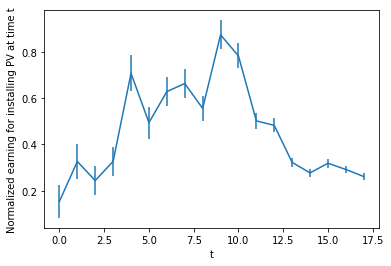

In [4]:
Earning=np.load("../data/Earning.npy")
print(f"The shape of the Earning matrix is {Earning.shape}")
print(f"The largest entry is {Earning.max()}, the smallest is {Earning.min()}.")
pl.errorbar(np.arange(18),Earning.mean(axis=1),Earning.var(axis=1)**0.5)
pl.ylabel("Normalized earning for installing PV at time t")
pl.xlabel("t")
pl.show()

Now we need the **Agent matrix to store all info about the individual agents** we need. The agent matrix consists of three columns. The first column is an identiciation number for each agent. The second column is the number of the county the agent lives in. The third column stores the info if the agent has adopted to the new technology and is either a 1 (adopted) or a 0 (not adopted). This third column will be updated at each timestep of the simulation.  
  
Note that the variable *Agent_Scale* shrinks down the model to achieve a faster computation. With the choosen value of 0.005, we do not use the original number of ~1.5e7 agents owning a house in Germany, but only 0.5% of that. Therefore, each agent in the simulation represents 200 agents in reality and the model has 79835 agents.

In [5]:
from CreateData_GIT import MakeAgentArray

Agent_Scale=0.005
Agent_Array=MakeAgentArray(Countypd,Agent_Scale)

print(Agent_Array.shape)
print(Agent_Array[1000])

(79835, 3)
[1000    7    0]


At last, we need the **data set we want to model**, namely the number of new adopters between 2000 and 2019 in each county. 

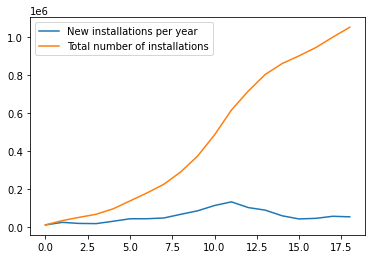

The shape of the PV Dataset is (19, 401)


In [6]:
from CreateData_GIT import Load_PVData
Y,Y_kummulative=Load_PVData()
pl.plot(Y.sum(axis=1),label="New installations per year")
pl.plot(Y_kummulative.sum(axis=1),label="Total number of installations")
pl.legend()
pl.show()
print(f"The shape of the PV Dataset is {Y.shape}")

One part of the explanatory data X should be some sort of opinion variable that reflects the opinion of agent i about adopting. This induces interaction among agents, e.g. if one chooses ideas like the *Relative Agreement model* [1,2]. In this toy model however, we draw a random initial opinion for each agent and change it randomly over time, where positive opinion changes are more likely than negative changes. This simplified opinion model has no interaction among agents and is much faster in terms of computation.
  
For each agent at every time t, the Opinion lies between -1 and 1. 

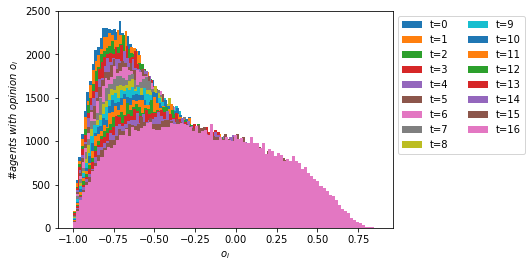

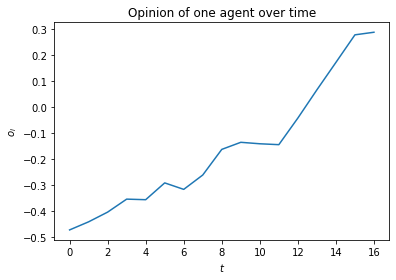

In [7]:
from CreateData_GIT import SimpleOpinionStep
Opinion=np.zeros((17,len(Agent_Array)))
Opinion[0]=2*np.random.beta(2,8,size=len(Agent_Array))-1
pl.hist(Opinion[0],bins=100,label="t=0")
for t in range(1,17):
    Opinion=SimpleOpinionStep(Opinion,t)
    pl.hist(Opinion[t],bins=100,label="t="+str(t))
pl.ylabel(r"$ \# agents\ with\ opinion\ o_i$")
pl.xlabel(r"$o_i$")
pl.legend(ncol=2,bbox_to_anchor=(1,1))
pl.show()
pl.plot(Opinion.transpose()[100])
pl.title("Opinion of one agent over time")
pl.ylabel(r"$o_i$")
pl.xlabel(r"$t$")
pl.show()

# 3) Defining the model
  
For detailed information about the model, we refer to the work "Efficiently Calibrating Agent-based Models of Innovation Diffusion".  
  
First we define a **linear utility**. This utility is the sum over the fitting parameters *params_i* times the explanatory variables *X_i*. The higher the value of the utility becomes, the more likely is an adoption of the agent.

In [8]:
def utility_func(params,X):
    utility=0.
    for i in range(len(params)):
        utility+=params[i]*X[i]
    return utility

Then we define the **function F, which maps the utility to an adoption probability** in [0,1]. Since we want to model a threshold adoption, the probability to adopt is 1 if the utility is positive and it is 0 if the utility is negative:

In [9]:
def F(utility):
    p_adopt=utility>0
    return p_adopt

Finally we reached the point where we **define the actual model**. The model function needs an array of four values as *params* and the number of years *Timesteps* as a whole number. The output is an array of the same shape as the PV installation array *Y*. It stands for the number of new adopters in each county for each point in time.  



In [10]:
def Model(params,Timesteps,Agent_Array,Countypd=Countypd,utility_func=utility_func,F=F,
          PopDensity=PopDensity,Agent_Scale=Agent_Scale,
          Income=Income,Earning=Earning):
    
    """Generate the part of X that is time independant"""
    CountyofAgent=Agent_Array.transpose()[1]
    X0=PopDensity[CountyofAgent]
    X1=Income[CountyofAgent]
    
    """Generate an initial opinion"""
    Opinion=np.zeros((Timesteps,len(Agent_Array)))
    Opinion[0]=2*np.random.beta(2,8,size=len(Agent_Array))-1
    
    """Generate an individual threshold for each agent"""
    threshold=np.random.beta(5,2,size=len(Agent_Array))
    
    """Define the PV_adopters matrix, which counts the number of new adopters at time t in county c"""
    PV_adopters=np.zeros((Timesteps,len(Countypd)))
    
    """Agents_where is a matrix, that has a 1 at place (county,agent) 
    if the agent lives in that county and a 0 if not. It is used to make the algorithm more efficient later."""
    Agents_where=np.zeros((len(Countypd),len(Agent_Array))).astype(bool)
    for i in range(len(Countypd)):
        Agents_where[i]=Agent_Array.transpose()[1]==i
    
    for t in range(1,Timesteps):
        """Generate the part of X that is time dependant"""
        Opinion=SimpleOpinionStep(Opinion,t)
        X2=(Opinion[t]+1)/2
        X3=Earning[t][CountyofAgent]
        
        X=np.array([X0,X1,X2,X3])
        
        utility=utility_func(params,X)
        p_adopt=F(utility-threshold)
        """Update the adoption variable within the Agent matrix"""
        Agent_Array[np.where(p_adopt==1)[0],2]=1
        """Count the number of new adopters"""
        PV_adopters[t]=np.stack((Agent_Array.transpose()[2],)*len(Countypd)).sum(axis=1,where=Agents_where)-PV_adopters[:t].sum(axis=0)
        
        print(f"New adopters at time {t}: {(PV_adopters[t]/Agent_Scale).sum()}")
    PV_adopters/=Agent_Scale
    
    print(f"Total number of adopters: {(PV_adopters).sum()}")
    return PV_adopters

Now we can run the model for the first time with some initial parameters. 

New adopters at time 1: 44000.0
New adopters at time 2: 0.0
New adopters at time 3: 6800.0
New adopters at time 4: 246200.0
New adopters at time 5: 0.0
New adopters at time 6: 1000.0
New adopters at time 7: 16000.0
New adopters at time 8: 0.0
New adopters at time 9: 362600.0
New adopters at time 10: 0.0
New adopters at time 11: 0.0
New adopters at time 12: 0.0
New adopters at time 13: 0.0
New adopters at time 14: 0.0
New adopters at time 15: 0.0
New adopters at time 16: 0.0
Total number of adopters: 676600.0
The shape of the output is (17, 401)


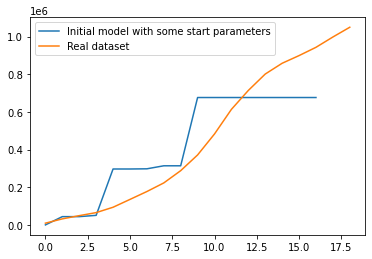

In [11]:
"""reset Agent_Array"""
Agent_Array=MakeAgentArray(Countypd,Agent_Scale)

"""Run the model once"""
initial_params=np.array([-.3,.3,.3,.3])
Timesteps=17
Y_tilde=Model(initial_params,Timesteps,Agent_Array)
print(f"The shape of the output is {Y_tilde.shape}")

pl.plot(Y_tilde.cumsum(axis=0).sum(axis=1),label="Initial model with some start parameters")
pl.plot(Y_kummulative.sum(axis=1),label="Real dataset")
pl.legend()
pl.plot()
pl.show()

# 4) Implementing the gradients
To calibrate the model, we have to introduce a **cost function C**. Here we use the sum over the squared residuals. 

In [13]:
"""reset Agent_Array"""
Agent_Array=MakeAgentArray(Countypd,Agent_Scale)

Timesteps=17
def Costfunction(params,Agent_Array,Y=Y[:Timesteps],Model=Model,Timesteps=Timesteps):
    Y_tilde=Model(params,Timesteps,Agent_Array)
    residuals=(Y-Y_tilde)**2
    return residuals.sum()

print(f"The value of the cost function is {Costfunction(initial_params,Agent_Array)}")

New adopters at time 1: 52200.0
New adopters at time 2: 0.0
New adopters at time 3: 8000.0
New adopters at time 4: 242600.0
New adopters at time 5: 0.0
New adopters at time 6: 1200.0
New adopters at time 7: 18800.0
New adopters at time 8: 0.0
New adopters at time 9: 357800.0
New adopters at time 10: 0.0
New adopters at time 11: 0.0
New adopters at time 12: 0.0
New adopters at time 13: 0.0
New adopters at time 14: 0.0
New adopters at time 15: 0.0
New adopters at time 16: 0.0
Total number of adopters: 680600.0
The value of the cost function is 939778892.0


An intuitive approach for calibrating agent-based adoption models is the use of black-box optimization algorithms that do not need gradients. The disatvantage of those algorithms is their slow convergence. Especially when using many free parameters, black-box optimization is not able to find a good solution within an acceptable time.  
Hence we will implement the gradients calculated in the paper "Efficiently Calibrating Agent-based Models of Innovation Diffusion".  

First, we have to modify the utility function and the F function from above. They now also return their gradients. (Note, that for *F_threshold_wgrad()* the gradient would actually be the delta distribution, but this will kill all gradients, hence we use the gradient to be =1)

In [14]:
def utility_func_wgrad(params,X):
    utility=0.
    for i in range(len(params)):
        utility+=params[i]*X[i]
    
    grad=X
    return utility,grad

def F_threshold_wgrad(utility):
    p_adopt=utility>0
    grad=np.ones(len(utility))
    return p_adopt,grad

def F_gaussian_wgrad(utility,sigma=1):
    p_adopt=0.5*(1+specialfunc.erf(utility/(2**0.5*sigma)))
    grad=1/(2*sigma**2)**0.5*np.exp(-1*utility**2/(2*sigma**2))
    return p_adopt,grad

Note that only the parts commented with *NEW* are added to the already defined *Model()*-function.

In [15]:
def Model_with_gradients(params,Timesteps,Countypd=Countypd,Agent_Array=Agent_Array,utility_func=utility_func_wgrad,
                         F=F_threshold_wgrad,PopDensity=PopDensity,Agent_Scale=Agent_Scale,Income=Income,Earning=Earning):
    
    """Generate the part of X that is time independant"""
    CountyofAgent=Agent_Array.transpose()[1]
    X0=PopDensity[CountyofAgent]
    X1=Income[CountyofAgent]
    
    """Generate an initial opinion"""
    Opinion=np.zeros((Timesteps,len(Agent_Array)))
    Opinion[0]=2*np.random.beta(2,8,size=len(Agent_Array))-1
    
    """Generate an individual threshold for each agent"""
    threshold=np.random.beta(5,2,size=len(Agent_Array))
    
    """Define the PV_adopters matrix, which counts the number of new adopters at time t in county c"""
    PV_adopters=np.zeros((Timesteps,len(Countypd)))
    
    """Agents_where is a matrix, that has a 1 in at place (county,agent) 
    if the agent lives in that county and a 0 if not. It is used to make the algorithm more efficient later."""
    Agents_where=np.zeros((len(Countypd),len(Agent_Array))).astype(bool)
    for i in range(len(Countypd)):
        Agents_where[i]=Agent_Array.transpose()[1]==i
        
    """NEW: Define the gradient matrices"""
    Grad_f_times_X=np.zeros((len(params),Timesteps,len(Countypd)))
    Grad_2_sum=np.zeros((len(params),Timesteps,len(Countypd)))
    Grad_temp_timesum=np.zeros((len(params),Timesteps,len(Agent_Array)))
    Grad_state1=np.zeros((16,Timesteps,len(Countypd)))
    Grad_state_sum=np.zeros((16,Timesteps,len(Countypd)))
    Grad_state_temp_timesum=np.zeros((16,Timesteps,len(Agent_Array)))
    Grad_prod_temp=np.zeros((Timesteps,len(Agent_Array)))
    Grad_prod_temp[0]=np.ones(len(Agent_Array))
    
    
    for t in range(1,Timesteps):
        """Generate the part of X that is time dependant"""
        Opinion=SimpleOpinionStep(Opinion,t)
        X2=(Opinion[t]+1)/2
        X3=Earning[t][CountyofAgent]
        
        X=np.array([X0,X1,X2,X3])
        
        utility,grad_utility=utility_func(params,X)
        p_adopt,grad_adopt=F(utility-threshold)
        
        """NEW: COMPUTE THE GRADIENTS"""
        
        epsilon=1e-8
        """Product part of the gradient"""
        Grad_prod_temp[t]=1-p_adopt
        Grad_prod=Grad_prod_temp[:t].prod(axis=0)
        
        for n in range(len(params)):
            """First Summand within the gradients"""
            grad_temp=grad_adopt*grad_utility[n]*Grad_prod
            Grad_f_times_X[n][t]=np.stack((grad_temp,)*len(Countypd)).sum(axis=1,where=Agents_where)
            """"Second Summand within the gradients"""
            Grad_temp_timesum[n][t]=grad_adopt*grad_utility[n]/(1-p_adopt+epsilon)
            Grad_2_sum_temp=Grad_temp_timesum[n][:t].sum(axis=0)*p_adopt*Grad_prod
            Grad_2_sum[n][t]=np.stack((Grad_2_sum_temp,)*len(Countypd)).sum(axis=1,where=Agents_where)
        
        
        
        """END OF: COMPUTE THE GRADIENTS"""
        
        """Update the adoption variable within the Agent matrix"""
        Agent_Array[np.where(p_adopt==1)[0],2]=1
        
        """Count the number of new adopters"""
        PV_adopters[t]=np.stack((Agent_Array.transpose()[2],)*len(Countypd)).sum(axis=1,where=Agents_where)-PV_adopters[:t].sum(axis=0)
        
        print(f"New adopters at time {t}: {(PV_adopters[t]/Agent_Scale).sum()}")
    
    """NEW: substract the two gradient parts from each other to get the final gradient"""
    Grad=Grad_f_times_X-Grad_2_sum
    
    PV_adopters/=Agent_Scale
    
    print(f"Total number of adopters: {(PV_adopters).sum()}")
    return PV_adopters,Grad

The new *Costfunction_with_Gradients* has the summed residuals as well as the gradients as its output.

In [16]:
def Costfunction_with_Gradients(params,Agent_Array,Y=Y[:Timesteps],Model=Model,Timesteps=Timesteps):
    Y_tilde,Grad_Y=Model_with_gradients(params,Timesteps,Agent_Array=Agent_Array)
    residuals=(Y-Y_tilde)**2
    
    """NEW: Calculate the gradients of the Cost function"""
    Grad=np.zeros(len(params))
    for n in range(len(params)):
        Grad_temp=(Y-Y_tilde)*Grad_Y[n]
        Grad[n]=-2*Grad_temp.sum()
    
    return residuals.sum(),Grad

In [17]:
"""reset Agent_Array"""
Agent_Array=MakeAgentArray(Countypd,Agent_Scale)

Costfunction_with_Gradients(initial_params,Agent_Array)

New adopters at time 1: 46200.0
New adopters at time 2: 0.0
New adopters at time 3: 8000.0
New adopters at time 4: 252000.0
New adopters at time 5: 0.0
New adopters at time 6: 400.0
New adopters at time 7: 17600.0
New adopters at time 8: 0.0
New adopters at time 9: 350000.0
New adopters at time 10: 0.0
New adopters at time 11: 0.0
New adopters at time 12: 0.0
New adopters at time 13: 0.0
New adopters at time 14: 0.0
New adopters at time 15: 0.0
New adopters at time 16: 0.0
Total number of adopters: 674200.0


(981615292.0,
 array([-21058957.23905209, -29745024.60867952, -65878864.07263684,
         -4371279.36088879]))

# 5) Calibrating the model
Now that we can calculate the gradients of the cost function with respect to the free parameters, we can use gradient-based optimizers for the model calibration. This has a huge advantage compared to use black-box optimizers, namely the relatively fast convergence even for many free parameters.  
  
Here we will use adam [3] as our optimizer of choice, but note that we could actually use any gradient-based algorithm, even simple ones such as gradient descent. 

In [18]:
def adam(params,grad_params,mt,vt,n,lr=0.05, beta=(0.3, 0.5),eps=1e-10):
    m_new=beta[0]*mt+(1-beta[0])*grad_params
    v_new=beta[1]*vt+(1-beta[1])*grad_params**2
    m_corr=m_new/(1-beta[0]**n)
    v_corr=v_new/(1-beta[1]**n)
    params_new=params-lr*m_corr/(v_corr**0.5+eps)
    print(f"The parameters are {params}")
    print(f"The gradient of the parameters is {-lr*m_corr/(v_corr**0.5+eps)}")
    return params_new,m_new,v_new

New adopters at time 1: 54000.0
New adopters at time 2: 0.0
New adopters at time 3: 6600.0
New adopters at time 4: 253000.0
New adopters at time 5: 0.0
New adopters at time 6: 1200.0
New adopters at time 7: 15800.0
New adopters at time 8: 0.0
New adopters at time 9: 359800.0
New adopters at time 10: 0.0
New adopters at time 11: 0.0
New adopters at time 12: 0.0
New adopters at time 13: 0.0
New adopters at time 14: 0.0
New adopters at time 15: 0.0
New adopters at time 16: 0.0
Total number of adopters: 690400.0
[-0.3  0.3  0.3  0.3]
[ 0.05  0.05  0.05 -0.05]
New adopters at time 1: 55000.0
New adopters at time 2: 0.0
New adopters at time 3: 10200.0
New adopters at time 4: 207200.0
New adopters at time 5: 0.0
New adopters at time 6: 4200.0
New adopters at time 7: 24200.0
New adopters at time 8: 0.0
New adopters at time 9: 311800.0
New adopters at time 10: 0.0
New adopters at time 11: 0.0
New adopters at time 12: 0.0
New adopters at time 13: 0.0
New adopters at time 14: 0.0
New adopters at 

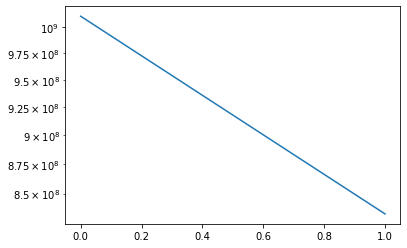

New adopters at time 1: 132200.0
New adopters at time 2: 0.0
New adopters at time 3: 20000.0
New adopters at time 4: 460800.0
New adopters at time 5: 0.0
New adopters at time 6: 8800.0
New adopters at time 7: 43800.0
New adopters at time 8: 0.0
New adopters at time 9: 620200.0
New adopters at time 10: 0.0
New adopters at time 11: 0.0
New adopters at time 12: 0.0
New adopters at time 13: 0.0
New adopters at time 14: 0.0
New adopters at time 15: 0.0
New adopters at time 16: 0.0
Total number of adopters: 1285800.0
[-0.20007165  0.40071413  0.40051535  0.29704047]
[-0.01028872 -0.0221234   0.02698172 -0.04533594]


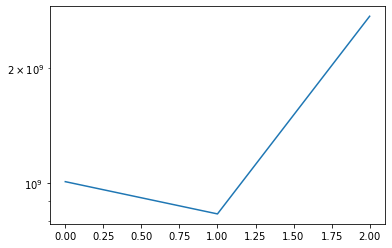

New adopters at time 1: 111400.0
New adopters at time 2: 600.0
New adopters at time 3: 22200.0
New adopters at time 4: 321800.0
New adopters at time 5: 0.0
New adopters at time 6: 9000.0
New adopters at time 7: 43800.0
New adopters at time 8: 0.0
New adopters at time 9: 435200.0
New adopters at time 10: 200.0
New adopters at time 11: 0.0
New adopters at time 12: 0.0
New adopters at time 13: 0.0
New adopters at time 14: 0.0
New adopters at time 15: 0.0
New adopters at time 16: 0.0
Total number of adopters: 944200.0
[-0.21036037  0.37859072  0.42749707  0.25170453]
[-0.00050665 -0.01902611  0.03946327 -0.04151122]


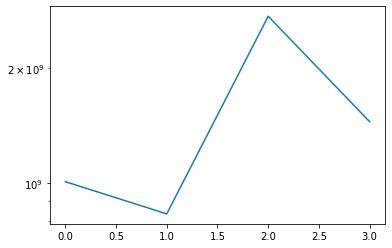

New adopters at time 1: 93400.0
New adopters at time 2: 1000.0
New adopters at time 3: 23200.0
New adopters at time 4: 238600.0
New adopters at time 5: 0.0
New adopters at time 6: 15800.0
New adopters at time 7: 42400.0
New adopters at time 8: 200.0
New adopters at time 9: 335200.0
New adopters at time 10: 3600.0
New adopters at time 11: 0.0
New adopters at time 12: 0.0
New adopters at time 13: 0.0
New adopters at time 14: 0.0
New adopters at time 15: 200.0
New adopters at time 16: 200.0
Total number of adopters: 753800.0
[-0.21086703  0.35956461  0.46696034  0.21019331]
[ 0.02974863  0.01667763  0.04933287 -0.02559518]


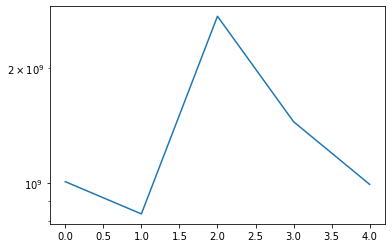

New adopters at time 1: 116400.0
New adopters at time 2: 2000.0
New adopters at time 3: 26200.0
New adopters at time 4: 230800.0
New adopters at time 5: 0.0
New adopters at time 6: 29000.0
New adopters at time 7: 52200.0
New adopters at time 8: 4200.0
New adopters at time 9: 313200.0
New adopters at time 10: 8200.0
New adopters at time 11: 0.0
New adopters at time 12: 0.0
New adopters at time 13: 0.0
New adopters at time 14: 0.0
New adopters at time 15: 1600.0
New adopters at time 16: 3200.0
Total number of adopters: 787000.0
[-0.18111839  0.37624224  0.51629321  0.18459813]
[ 0.01788502  0.01531307  0.04921007 -0.02709154]


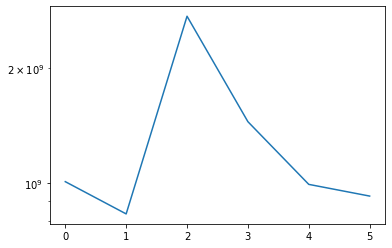

New adopters at time 1: 136000.0
New adopters at time 2: 5400.0
New adopters at time 3: 33400.0
New adopters at time 4: 211000.0
New adopters at time 5: 0.0
New adopters at time 6: 43400.0
New adopters at time 7: 60600.0
New adopters at time 8: 7800.0
New adopters at time 9: 309200.0
New adopters at time 10: 21600.0
New adopters at time 11: 0.0
New adopters at time 12: 2000.0
New adopters at time 13: 600.0
New adopters at time 14: 2200.0
New adopters at time 15: 14800.0
New adopters at time 16: 10400.0
Total number of adopters: 858400.0
[-0.16323337  0.3915553   0.56550328  0.15750659]
[-0.01403756 -0.02337941  0.04593976 -0.03751036]


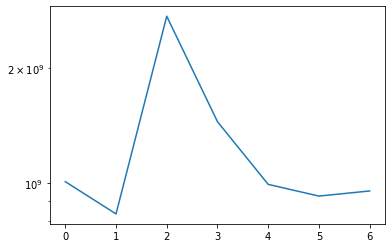

New adopters at time 1: 139800.0
New adopters at time 2: 10600.0
New adopters at time 3: 32200.0
New adopters at time 4: 160600.0
New adopters at time 5: 2000.0
New adopters at time 6: 51000.0
New adopters at time 7: 54600.0
New adopters at time 8: 16400.0
New adopters at time 9: 233400.0
New adopters at time 10: 28800.0
New adopters at time 11: 200.0
New adopters at time 12: 12400.0
New adopters at time 13: 2800.0
New adopters at time 14: 8000.0
New adopters at time 15: 31800.0
New adopters at time 16: 27000.0
Total number of adopters: 811600.0
[-0.17727093  0.36817589  0.61144304  0.11999623]
[-0.00707283 -0.0200737   0.04708005 -0.02492698]


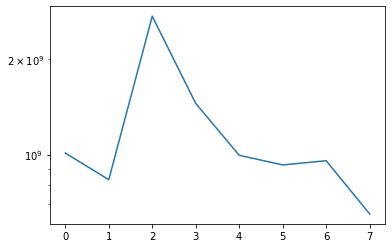

New adopters at time 1: 129800.0
New adopters at time 2: 13600.0
New adopters at time 3: 31400.0
New adopters at time 4: 131400.0
New adopters at time 5: 8000.0
New adopters at time 6: 54800.0
New adopters at time 7: 55400.0
New adopters at time 8: 22400.0
New adopters at time 9: 189400.0
New adopters at time 10: 46800.0
New adopters at time 11: 4200.0
New adopters at time 12: 25200.0
New adopters at time 13: 11400.0
New adopters at time 14: 30200.0
New adopters at time 15: 50600.0
New adopters at time 16: 55200.0
Total number of adopters: 859800.0
[-0.18434376  0.34810219  0.65852309  0.09506926]
[-0.04163314 -0.04234352  0.04146282 -0.01884527]


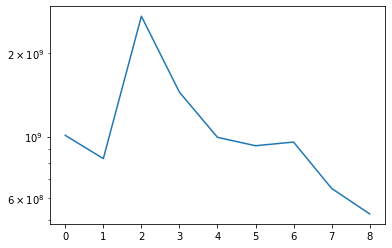

New adopters at time 1: 132800.0
New adopters at time 2: 16800.0
New adopters at time 3: 30600.0
New adopters at time 4: 107000.0
New adopters at time 5: 13000.0
New adopters at time 6: 52600.0
New adopters at time 7: 50000.0
New adopters at time 8: 35400.0
New adopters at time 9: 163200.0
New adopters at time 10: 52400.0
New adopters at time 11: 11400.0
New adopters at time 12: 42600.0
New adopters at time 13: 22800.0
New adopters at time 14: 35800.0
New adopters at time 15: 69200.0
New adopters at time 16: 73400.0
Total number of adopters: 909000.0
[-0.2259769   0.30575867  0.69998591  0.07622398]
[-0.04196022 -0.04849686  0.03415164 -0.01240778]


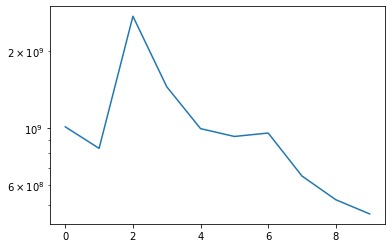

New adopters at time 1: 113800.0
New adopters at time 2: 17600.0
New adopters at time 3: 29000.0
New adopters at time 4: 80600.0
New adopters at time 5: 17000.0
New adopters at time 6: 48800.0
New adopters at time 7: 55200.0
New adopters at time 8: 39600.0
New adopters at time 9: 137000.0
New adopters at time 10: 57400.0
New adopters at time 11: 21400.0
New adopters at time 12: 45600.0
New adopters at time 13: 35400.0
New adopters at time 14: 42800.0
New adopters at time 15: 82200.0
New adopters at time 16: 84200.0
Total number of adopters: 907600.0
[-0.26793711  0.25726181  0.73413756  0.06381621]
[ 0.02241677 -0.04142148  0.03204724  0.01927463]


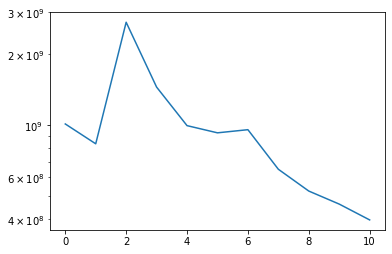

New adopters at time 1: 138400.0
New adopters at time 2: 15400.0
New adopters at time 3: 41200.0
New adopters at time 4: 108000.0
New adopters at time 5: 14800.0
New adopters at time 6: 65600.0
New adopters at time 7: 65400.0
New adopters at time 8: 40400.0
New adopters at time 9: 186400.0
New adopters at time 10: 66800.0
New adopters at time 11: 14400.0
New adopters at time 12: 47800.0
New adopters at time 13: 28400.0
New adopters at time 14: 47200.0
New adopters at time 15: 91800.0
New adopters at time 16: 85800.0
Total number of adopters: 1057800.0
[-0.24552034  0.21584033  0.7661848   0.08309083]
[-0.04269616 -0.05244243 -0.01329862 -0.04359376]


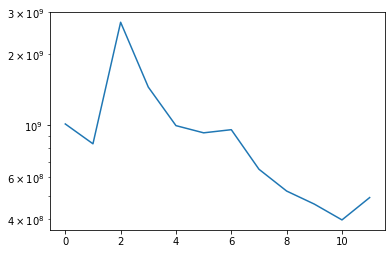

New adopters at time 1: 82800.0
New adopters at time 2: 16400.0
New adopters at time 3: 22000.0
New adopters at time 4: 47200.0
New adopters at time 5: 16200.0
New adopters at time 6: 37400.0
New adopters at time 7: 46400.0
New adopters at time 8: 34600.0
New adopters at time 9: 80000.0
New adopters at time 10: 52000.0
New adopters at time 11: 31000.0
New adopters at time 12: 53400.0
New adopters at time 13: 41400.0
New adopters at time 14: 55600.0
New adopters at time 15: 83000.0
New adopters at time 16: 75600.0
Total number of adopters: 775000.0
[-0.28821649  0.16339789  0.75288617  0.03949707]
[0.02941514 0.01694944 0.04085325 0.03515041]


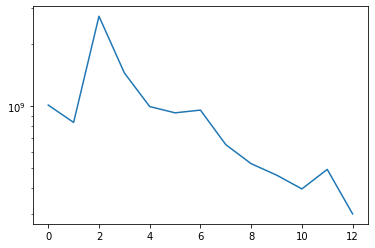

New adopters at time 1: 129600.0
New adopters at time 2: 17400.0
New adopters at time 3: 34200.0
New adopters at time 4: 111000.0
New adopters at time 5: 21200.0
New adopters at time 6: 63000.0
New adopters at time 7: 79800.0
New adopters at time 8: 41600.0
New adopters at time 9: 174000.0
New adopters at time 10: 69600.0
New adopters at time 11: 21400.0
New adopters at time 12: 49200.0
New adopters at time 13: 36800.0
New adopters at time 14: 63600.0
New adopters at time 15: 99400.0
New adopters at time 16: 89000.0
Total number of adopters: 1100800.0
[-0.25880136  0.18034733  0.79373942  0.07464748]
[-0.00021354 -0.03499738 -0.01283857 -0.02210198]


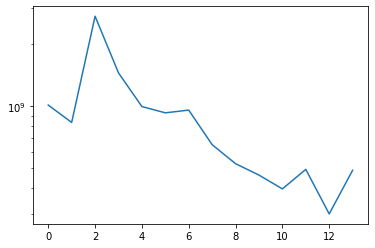

New adopters at time 1: 99600.0
New adopters at time 2: 17600.0
New adopters at time 3: 28200.0
New adopters at time 4: 66600.0
New adopters at time 5: 19600.0
New adopters at time 6: 51600.0
New adopters at time 7: 51800.0
New adopters at time 8: 34200.0
New adopters at time 9: 114000.0
New adopters at time 10: 61200.0
New adopters at time 11: 25000.0
New adopters at time 12: 49600.0
New adopters at time 13: 41200.0
New adopters at time 14: 54200.0
New adopters at time 15: 92400.0
New adopters at time 16: 81600.0
Total number of adopters: 888400.0
[-0.25901489  0.14534996  0.78090085  0.0525455 ]
[ 0.02249549 -0.00078845  0.02225366  0.01454776]


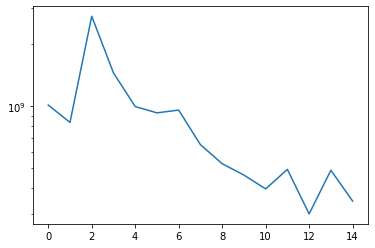

New adopters at time 1: 121000.0
New adopters at time 2: 19600.0
New adopters at time 3: 33200.0
New adopters at time 4: 95400.0
New adopters at time 5: 23200.0
New adopters at time 6: 67000.0
New adopters at time 7: 67600.0
New adopters at time 8: 48800.0
New adopters at time 9: 159400.0
New adopters at time 10: 65000.0
New adopters at time 11: 25600.0
New adopters at time 12: 63000.0
New adopters at time 13: 42000.0
New adopters at time 14: 61400.0
New adopters at time 15: 106400.0
New adopters at time 16: 97600.0
Total number of adopters: 1096200.0
[-0.23651941  0.1445615   0.80315451  0.06709326]
[-0.03717779 -0.04134619 -0.03140586 -0.03240201]


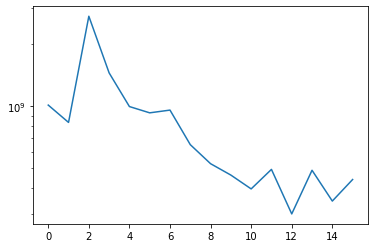

New adopters at time 1: 72800.0
New adopters at time 2: 17000.0
New adopters at time 3: 22200.0
New adopters at time 4: 47400.0
New adopters at time 5: 18000.0
New adopters at time 6: 41400.0
New adopters at time 7: 39400.0
New adopters at time 8: 33600.0
New adopters at time 9: 80000.0
New adopters at time 10: 51800.0
New adopters at time 11: 34000.0
New adopters at time 12: 52400.0
New adopters at time 13: 48200.0
New adopters at time 14: 57400.0
New adopters at time 15: 72600.0
New adopters at time 16: 81600.0
Total number of adopters: 769800.0
[-0.27369719  0.10321531  0.77174865  0.03469125]
[0.03592676 0.02792112 0.03666901 0.03601819]


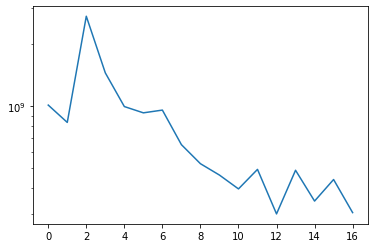

New adopters at time 1: 127200.0
New adopters at time 2: 18200.0
New adopters at time 3: 35200.0
New adopters at time 4: 96400.0
New adopters at time 5: 16800.0
New adopters at time 6: 62800.0
New adopters at time 7: 66400.0
New adopters at time 8: 42600.0
New adopters at time 9: 160400.0
New adopters at time 10: 70600.0
New adopters at time 11: 21400.0
New adopters at time 12: 59200.0
New adopters at time 13: 43200.0
New adopters at time 14: 55600.0
New adopters at time 15: 95400.0
New adopters at time 16: 96600.0
Total number of adopters: 1068000.0
[-0.23777043  0.13113643  0.80841765  0.07070944]
[-0.00980528 -0.02187219 -0.0098671  -0.01254599]


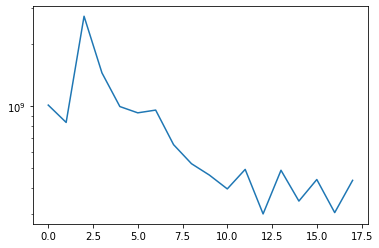

New adopters at time 1: 108000.0
New adopters at time 2: 18600.0
New adopters at time 3: 30400.0
New adopters at time 4: 72800.0
New adopters at time 5: 23000.0
New adopters at time 6: 49800.0
New adopters at time 7: 56800.0
New adopters at time 8: 43800.0
New adopters at time 9: 128600.0
New adopters at time 10: 67000.0
New adopters at time 11: 23400.0
New adopters at time 12: 56600.0
New adopters at time 13: 44200.0
New adopters at time 14: 60200.0
New adopters at time 15: 82800.0
New adopters at time 16: 94400.0
Total number of adopters: 960400.0
[-0.24757571  0.10926424  0.79855055  0.05816345]
[ 0.00764588 -0.01546512  0.00148659  0.0008384 ]


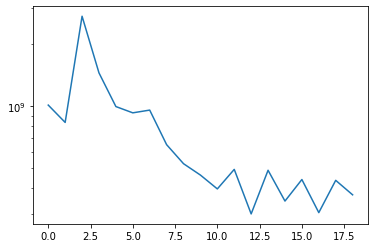

New adopters at time 1: 101600.0
New adopters at time 2: 18000.0
New adopters at time 3: 28400.0
New adopters at time 4: 73200.0
New adopters at time 5: 20800.0
New adopters at time 6: 48200.0
New adopters at time 7: 56600.0
New adopters at time 8: 43600.0
New adopters at time 9: 127000.0
New adopters at time 10: 58600.0
New adopters at time 11: 28400.0
New adopters at time 12: 59800.0
New adopters at time 13: 36600.0
New adopters at time 14: 63200.0
New adopters at time 15: 91400.0
New adopters at time 16: 88400.0
Total number of adopters: 943800.0
[-0.23992983  0.09379912  0.80003714  0.05900186]
[ 0.01897495 -0.00868648  0.01048484  0.0127502 ]


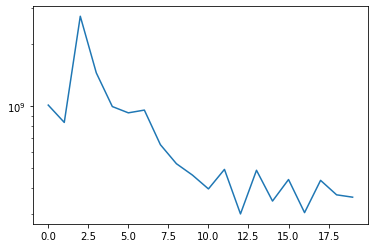

New adopters at time 1: 112200.0
New adopters at time 2: 18600.0
New adopters at time 3: 28800.0


In [ ]:
OptimizationSteps=40
mt=0
vt=0
params = initial_params
c_list=[]
    
for n in range(1,OptimizationSteps):
    """reset Agent_Array"""
    Agent_Array=MakeAgentArray(Countypd,Agent_Scale)
    
    c,grad=Costfunction_with_Gradients(params,Agent_Array)
    c_list.append(c)
    params,mt,vt=adam(params,grad,mt,vt,n)   
    if len(c_list)>1:
        pl.plot(c_list)
        pl.yscale("log")
        pl.show()

In [ ]:
"""reset Agent_Array"""
Agent_Array=MakeAgentArray(Countypd,Agent_Scale)

pl.plot(Y_tilde.cumsum(axis=0).sum(axis=1),label="Initial model with some start parameters")
pl.plot(Model(params,Timesteps,Agent_Array).cumsum(axis=0).sum(axis=1),label="Model after optimization")
pl.plot(Y_kummulative.sum(axis=1),label="Real dataset")
pl.legend()
pl.plot()
pl.show()

# Resources

[1] Deffuant, Guillaume, et al. "Mixing beliefs among interacting agents." Advances in Complex Systems 3.01n04 (2000): 87-98.  
[2] Deffuant, Guillaume, et al. "How can extremism prevail? A study based on the relative agreement interaction model." Journal of artificial societies and social simulation 5.4 (2002).  
[3] Kingma, D. P., & Ba, J. (2014). Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980.